In [171]:
import tensorflow as tf
import numpy as np
from utils import change_header
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers, utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    MaxPooling1D,
    Concatenate,
    GlobalAveragePooling2D,
    Input,
)
import re

# METHOD = 'Librosa'
# train_METHOD = 'Librosa'
# test_METHOD = 'Librosa'

# METHOD = "Morphvox_Pro"
# train_METHOD = "Morphvox_Pro"
# test_METHOD = "Morphvox_Pro"

# METHOD = "TD-PSOLA"
# train_METHOD = "TD-PSOLA"
# test_METHOD = "TD-PSOLA"

test_METHOD = "change_header"

# SAMPLE_RATE = 32000
# SAMPLE_RATE = 44100 
# SAMPLE_RATE = 48000
# SAMPLE_RATE = 50000
# SAMPLE_RATE = 96000
train_dir,test_dir = change_header.gen_dataset_file_path(9000, 13000, 1000,).train_test
test_file = test_dir[4]
hz = re.findall(r'\d+',test_file)
print(
    "Version:%s" % tf.__version__,
    "\nCUDA:%s" % tf.test.is_built_with_cuda(),
    "\nGPU:%s" % tf.test.is_built_with_gpu_support(),
)

Version:2.2.0 
CUDA:True 
GPU:True


In [172]:
# trainData = np.load(f"./pre-train/{train_METHOD}/Data-train-{SAMPLE_RATE}.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train-{SAMPLE_RATE}.npy", allow_pickle=True)
validData = np.load("./pre-valid/Librosa/Data-valid.npy", allow_pickle=True)
validLabel = np.load("./pre-valid/Librosa/Label-valid.npy", allow_pickle=True)
pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-{test_file}.npy", allow_pickle=True)
pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-{test_file}.npy", allow_pickle=True)

In [173]:


trainData = np.load(f"./pre-train/Data-All-change_header.npy", allow_pickle=True)
trainLabel = np.load(f"./pre-train/Label-All-change_header.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/Data-All-{SAMPLE_RATE}.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/Label-All-{SAMPLE_RATE}.npy", allow_pickle=True)

In [174]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(trainLabel)
trainLabel = le.transform(trainLabel)
validLabel = le.transform(validLabel)
pitchShiftTestLabel = le.transform(pitchShiftTestLabel)
# le2 = preprocessing.LabelEncoder()
# le2.fit(melTrainLabel)
# melTrainLabel = le2.transform(melTrainLabel)
# melValidLabel = le2.transform(melValidLabel)

In [101]:
def mlp(shape: int):
    """創建多層感知機
    
    Arguments:
        shape {int} -- [矩陣維度]
    
    Returns:
        Sequential 
    """
    return Sequential(
        [
            Dense(256, input_shape=(shape,), activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(10, activation="softmax"),
        ]
    )


def cnn(shape: tuple):
    """創建多層二維迴旋積分
    
    Arguments:
        shape {tuple} -- [矩陣維度]
    
    Returns:
        Sequential 
    """

    shape1, shape2, shape3 = shape
    inputA = Input((shape2, shape3))
    #     inputB = Input((shape2, shape3))
    x_1 = Conv1D(filters=64, kernel_size=32, activation="relu", padding="same",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(inputA)
    x_1 = MaxPooling1D(pool_size=8, strides=8)(x_1)
    x_1 = Dropout(0.5)(x_1)
    x_1 = Conv1D(
            filters=32, kernel_size=16, strides=4, activation="relu", padding="same",
        )(x_1)
    #     x_1 = MaxPooling1D(pool_size=4, strides=4)(x_1)
    #     x_1 = Dropout(0.5)(x_1)
    x_1 = Flatten()(x_1)
    x_2 = Conv1D(filters=128, kernel_size=32, activation="relu", padding="same",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(
        inputA
    )
    x_2 = MaxPooling1D(pool_size=4, strides=4)(x_2)
    x_2 = Dropout(0.5)(x_2)
    x_2 = Conv1D(
            filters=64, kernel_size=16, strides=18, activation="relu", padding="same",
        )(x_2)
    #     x_2 = MaxPooling1D(pool_size=2, strides=2)(x_2)
    #     x_2 = Dropout(0.5)(x_2)
    x_2 = Flatten()(x_2)

    combined = Concatenate()([x_1, x_2])
    drop_1 = Dropout(0.7)(combined)
    Den_1 = Dense(512, activation="relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(drop_1)
    Den_2 = Dense(512, activation="relu",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),)(Den_1)
    #     Den_1 = Dropout(0.5)(Den_1)
    #     Den_1 = Dense(256, activation="relu")(Den_1)
    #     Den_1 = Dropout(0.5)(Den_1)
    Den_3 = Dense(10, activation="softmax")(Den_2)
    model = Model(inputs=inputA, outputs=Den_3)
    return model

In [105]:
model = mlp(trainData.shape[1])
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [175]:
trainLabel = utils.to_categorical(trainLabel)
validLabel = utils.to_categorical(validLabel)
pitchShiftTestLabel = utils.to_categorical(pitchShiftTestLabel)

In [ ]:
# utils.plot_model(
#     model, show_shapes=True,
# )

In [107]:
history = model.fit(
    trainData,
    trainLabel,
    validation_data=(validData, validLabel),
    verbose=0,  # 不顯示過程
    epochs=500,
    batch_size=128,
)

In [108]:
model.evaluate(validData, validLabel)

4/4 [==============================] - 0s 959us/step - loss: 0.7469 - accuracy: 0.8700


[0.7469398379325867, 0.8700000047683716]

In [130]:
model.evaluate(pitchShiftTestData, pitchShiftTestLabel)

4/4 [==============================] - 0s 829us/step - loss: 0.6851 - accuracy: 0.8900


[0.6850888729095459, 0.8899999856948853]

In [112]:
model2 = cnn(trainData.reshape(3800, 277, 1).shape)
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# utils.plot_model(
#     model2, show_shapes=True,
# )

In [ ]:
history2 = model2.fit(
    trainData.reshape(3800, 277, 1),
    trainLabel,
    validation_data=(validData.reshape(100, 277, 1), validLabel),
    verbose=1,  # 不顯示過程
    epochs=100,
    batch_size=512,
)

In [167]:
model2.evaluate(validData.reshape(100, 277, 1), validLabel)

4/4 [==============================] - 0s 2ms/step - loss: 0.6315 - accuracy: 0.8900


[0.6314609050750732, 0.8899999856948853]

In [168]:
model2.evaluate(pitchShiftTestData.reshape(100, 277, 1), pitchShiftTestLabel)

4/4 [==============================] - 0s 2ms/step - loss: 0.8281 - accuracy: 0.8300


[0.8281140923500061, 0.8299999833106995]

4/4 [==============================] - 0s 1ms/step - loss: 1.0062 - accuracy: 0.8100


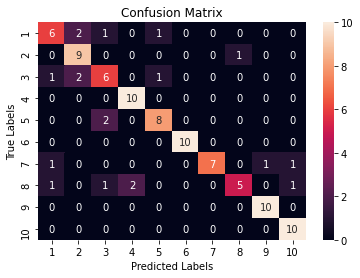

In [176]:
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.metrics import confusion_matrix

yp=model.predict(pitchShiftTestData)
yp=np.argmax(yp,axis=1)
yt=np.argmax(pitchShiftTestLabel,axis=1)
   

ax= plt.subplot()
cm=confusion_matrix(yt, yp)
sns.heatmap(cm, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
loss,acc=model.evaluate(pitchShiftTestData, pitchShiftTestLabel)
loss,acc=str(loss)[0:6],str(acc*100)[0:2]

4/4 [==============================] - 0s 2ms/step - loss: 0.9397 - accuracy: 0.8300


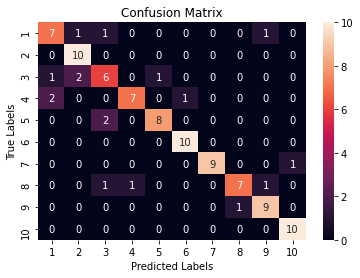

In [177]:


yp=model2.predict(pitchShiftTestData.reshape(100, 277, 1))
yp=np.argmax(yp,axis=1)
yt=np.argmax(pitchShiftTestLabel,axis=1)
   

ax= plt.subplot()
cm=confusion_matrix(yt, yp)
sns.heatmap(cm, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
loss2,acc2=model2.evaluate(pitchShiftTestData.reshape(100, 277, 1), pitchShiftTestLabel)
loss2,acc2=str(loss2)[0:6],str(acc2*100)[0:2]

In [178]:
temp=f"""
表三十四. 測試資是資取樣頻率為：{hz.pop()} ,訓練資料為包含：Librosa,Morphvox_Pro,TD-PSOLA,有更改過檔案標頭(合併在一起)
|  Model  |         訓練參數          | Valid Data 正確率 | Test Data 正確率 | Loss(Test) |
|:-------:|:-------------------------:|:-----------------:|:----------------:|:----------:|
| **MLP** | epochs=1000,batch_size=128 |        86%        |       {acc}%        |  {loss}  |
| **CNN** | epochs=500,batch_size=128  |        89%        |       {acc2}%        | {loss2}   |

|      Model       |               **MLP**                |               **CNN**                |
|:----------------:|:------------------------------------:|:------------------------------------:|
| **Comfusion Matrix** |![](https://i.imgur.com/hqp5AUc.png)|![](https://i.imgur.com/Mcq5n3A.png)|
"""
print(temp)


表三十四. 測試資是資取樣頻率為：13000 ,訓練資料為包含：Librosa,Morphvox_Pro,TD-PSOLA,有更改過檔案標頭(合併在一起)
|  Model  |         訓練參數          | Valid Data 正確率 | Test Data 正確率 | Loss(Test) |
|:-------:|:-------------------------:|:-----------------:|:----------------:|:----------:|
| **MLP** | epochs=1000,batch_size=128 |        86%        |       81%        |  1.0061  |
| **CNN** | epochs=500,batch_size=128  |        89%        |       82%        | 0.9397   |

|      Model       |               **MLP**                |               **CNN**                |
|:----------------:|:------------------------------------:|:------------------------------------:|
| **Comfusion Matrix** |![](https://i.imgur.com/hqp5AUc.png)|![](https://i.imgur.com/Mcq5n3A.png)|



In [ ]:
# trainData = np.load(f"./pre-train/TD-PSOLA/Data-train.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-pitchShiftTest.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-pitchShiftTest.npy", allow_pickle=True)


# trainData = np.load(f"./pre-train/{train_METHOD}/Data-train.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-pitchShiftTest.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-pitchShiftTest.npy", allow_pickle=True)


# trainData = np.load(f"./pre-train/{train_METHOD}/Data-train.npy", allow_pickle=True)
# trainLabel = np.load(f"./pre-train/{train_METHOD}/Label-train.npy", allow_pickle=True)

# pitchShiftTestData = np.load(f"./pre-test/{test_METHOD}/Data-pitchShiftTest.npy", allow_pickle=True)
# pitchShiftTestLabel = np.load(f"./pre-test/{test_METHOD}/Label-pitchShiftTest.npy", allow_pickle=True)

